# Data Lab 11

1. Spatial data
2. SVD
3. Finding Nino 3.4

How putting our data in a big matrix helps to understand it.

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [2]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

## 1. Spatial data

Often weather/climate data is large in the sense of occupying many bytes.

Climate data can result from
1. Measurements (2 general types)
    - Remote sensing
    - In situ
2. Simulations (2 general types)
    - Forecast
    - Simulations
3. Estimates (a mixture of 1 and 2)  
    - Reanalysis (state estimation = Kalman filter = observations + model-based first-guess)
    - weighted average
    
of some meterological qualitity such as temperature, pressure, or wind at specific location and time.

The words "location" and "time" suggest a data model where say temperature is represented
$$T(\text{location}, \text{time})$$


Suppose that the data are available (e.g., observed) at discrete times $t_1, t_2, \dots, t_N$ and locations $L_1, L_2, \dots, L_M$. Then,

$$ \text{temperature} = T(L_i, t_j) = T_{ij} = M \times N\, \text{matrix} $$

The data have the form of a **matrix**, **table**, or **2D array**.

(What about ship measurements?)

s = parameteric curve variable for the ship

$$[location(s), time(s), T(s)]$$

**(This is a column-major model of the data)**

Data varies fastest as you go down a column

In [3]:
np.arange(8).reshape(2, 4, order = 'F')

array([[0, 2, 4, 6],
       [1, 3, 5, 7]])

### 1.1 The world is big and time is short

Often
$$ M \gg N $$

The matrix $T$ is tall.

$t_{i + 1} - t_i = \Delta t$

Typical values of $N$ for 
1. $\Delta t $ = 1 year
2. $\Delta t $ = 1 month
3. $\Delta t $ = 1 day

Typical starts might be 1900 or 1979.

$\Delta t$ often sets both the frequency of the data and the resolution (averaging window). 

Here the frequency of the data is one value per year and the quantity is the annual average.

![](images/NASA_GISS_global_mean.png)

But not always. Annual frequency, seasonal resolution.

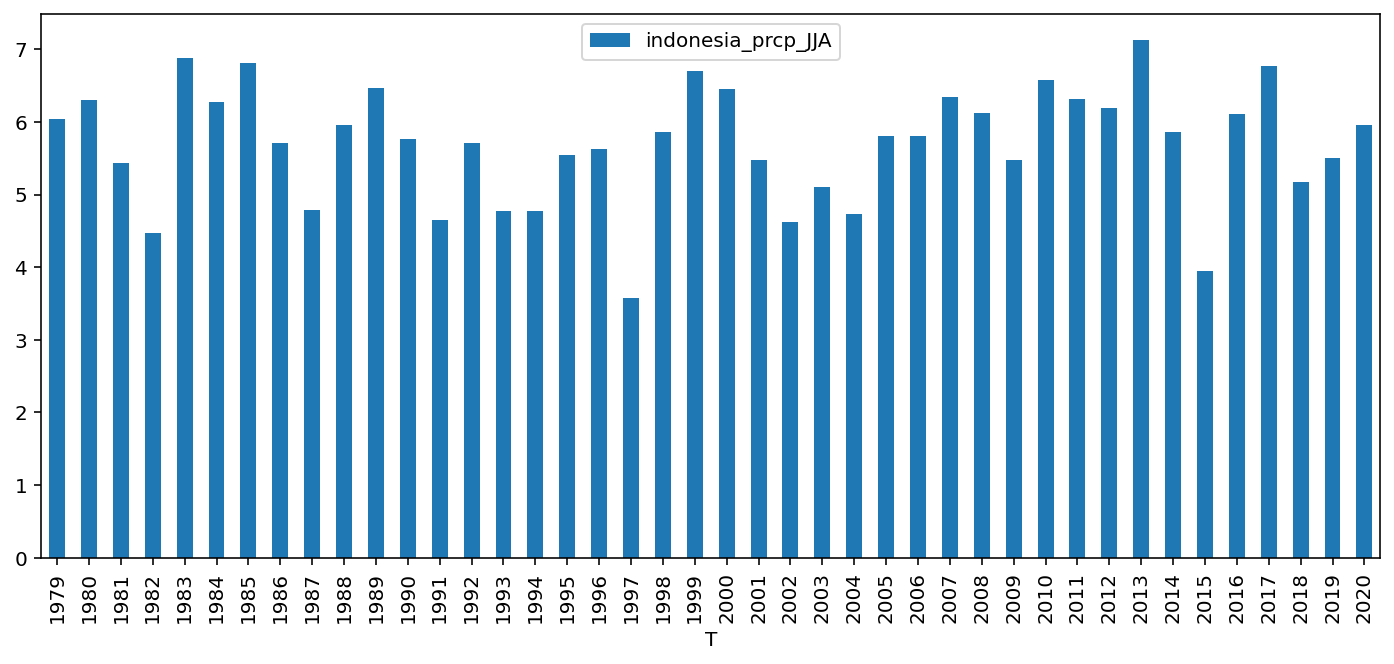

In [4]:
ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.indonesia_prcp_JJA/dods')
df = ds.to_dataframe()
df.plot.bar(figsize = (12, 5))
ax = plt.gca()

ax.set_xticklabels([pandas_datetime.strftime("%Y") for pandas_datetime in df.index]);

### 1.2 Satellite data

![](https://www.goes-r.gov/imagesContent/mission/goesHistory/History_of_GOES.jpg)

https://www.goes-r.gov/mission/history.html

### 1.3 How many locations?

![](https://oceanservice.noaa.gov/education/planet-stewards/images/webinar.png)

Depends on the size of the horizontal boxes and number of vertical levels.

$M$ = number of locations = $M_x \times M_y$ = number longitude boxes times number of lattitude boxes

If we use $1^\circ \times 1^\circ$ boxes, $M_x = 360$, $M_y = 180$, and $M = 64,800$

(In the tropics, 1 degree = 111 km)

1/2 degreee boxes $M = $

Versus $N = $ 

How many numbers?

Goal: Represent/approximate the data in a way that is
1. Efficient to store
2. Easier to understand
3. A good approximation 

In [5]:
2 * 180 * 2 * 360

259200

In [6]:
100 * 365

36500

Our data often takes the form of a very tall matrix $T$.

What is the rank of $T$? ($M \times N$)

What does that mean?

## 2. Example: Tropical SST

In [7]:
# Construct the url pointing to the data
dl_loc = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
region_str = 'Y/-30/30/RANGE/'
time_str = 'T/(Jan%201980)/last/RANGE/'
time_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'
sst_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + region_str + 'zlev/removeGRID/' + time_fix + 'dods'
sst_url

'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201980)/last/RANGE/Y/-30/30/RANGE/zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

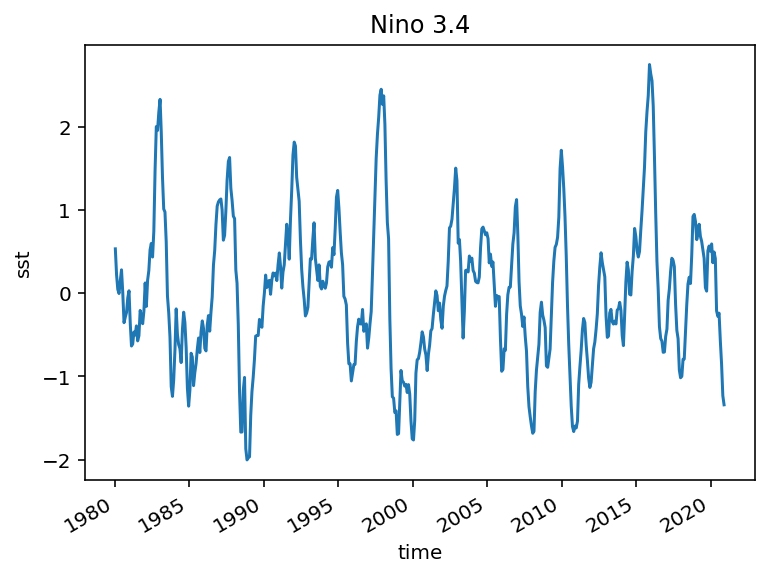

In [10]:
# Nino 3.4
nino34_str = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES%5BX/Y%5Daverage/'

n34_url = 'https://iridl.ldeo.columbia.edu/' + dl_loc + time_str + nino34_str + 'zlev/removeGRID/' + time_fix + 'dods'

n34_ds = xr.open_dataset(n34_url)
n34a = n34_ds.sst.groupby('T.month') - n34_ds.sst.groupby('T.month').mean('T')
n34a.plot();
plt.title('Nino 3.4');

In [12]:
# Open the SST dataset
sst_ds = xr.open_dataset(sst_url)
sst_ds

<xarray.Dataset>
Dimensions:  (T: 491, X: 180, Y: 31)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * Y        (Y) float32 -30.0 -28.0 -26.0 -24.0 -22.0 ... 24.0 26.0 28.0 30.0
  * T        (T) datetime64[ns] 1980-01-16T12:00:00 ... 2020-11-16
Data variables:
    sst      (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

In [13]:
# Pull out the grids (coordinates) and their lengths
X = sst_ds.X
Y = sst_ds.Y
T = sst_ds.T

nx = X.size
ny = Y.size
nt = T.size
print(nt, ny ,nx)
sst_ds.sst.shape

491 31 180


(491, 31, 180)

In [18]:
# Remove the mean (compute the anomalies)
sst = sst_ds.sst
sst.load()
ssta = sst.groupby('T.month') - sst.groupby('T.month').mean('T')
ssta

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


<xarray.DataArray 'sst' (T: 491, Y: 31, X: 180)>
array([[[ 0.29153252,  0.20361137,  0.10206985, ...,  0.49467087,
          0.44766426,  0.3689747 ],
        [ 0.18572044,  0.10891724,  0.0175457 , ...,  0.38106728,
          0.368515  ,  0.2874794 ],
        [ 0.07363701,  0.01180649, -0.05672646, ...,  0.24539375,
          0.2321701 ,  0.17066956],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[ 0.36766243,  0.27153778,  0.15734482, ...,  0.5848026 ,
          0.53611565,  0.45139885],
        [ 0.26233864,  0.19643593,  0.10081673, ...,  0.40284157,
          0.4082737 ,  0.34602356],
        [ 0.14329338,  0.10339165,  0.03352547, ...,  0.19665909,
          0.22260475,  0.20370483],
...
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-0.12275696, -0.07427216, -0.0254097 , ..., -0.34625053,
         -0.27406502, -0.18806648],
        [-0.11795998, -0.06819534, -0.02248955, ..., -0.27917862,
         -0.24413681, -0.18525124],
        [-0.10994911, -0.07139778, -0.04092598, ..., -0.22557259,
         -0.20835686, -0.16135979],
        ...,
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * X        (X) float32 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0
  * Y        (Y) float32 -30.0 -28.0 -26.0 -24.0 -22.0 ... 24.0 26.0 28.0 30.0
  * T        (T) datetime64[ns] 1980-01-16T12:00:00 ... 2020-11-16
    month    (T) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10 11

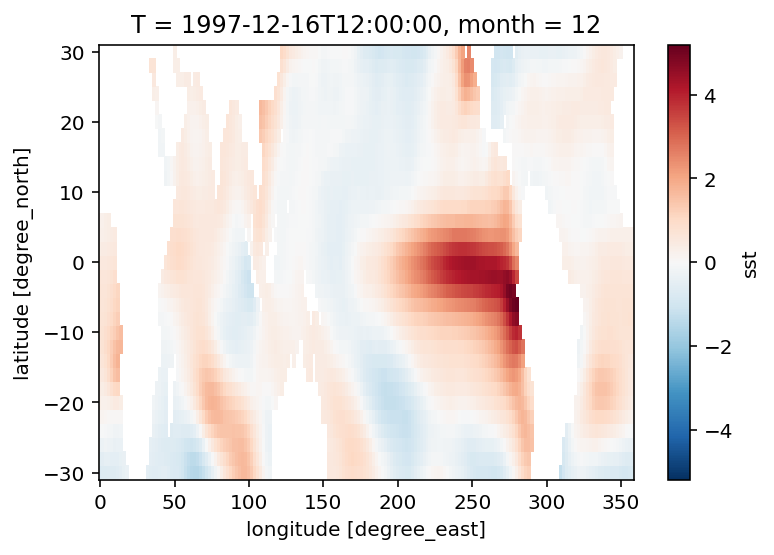

In [19]:
# Plot a value
ssta.sel(T='1997-12').plot();

### 2.1 SST map

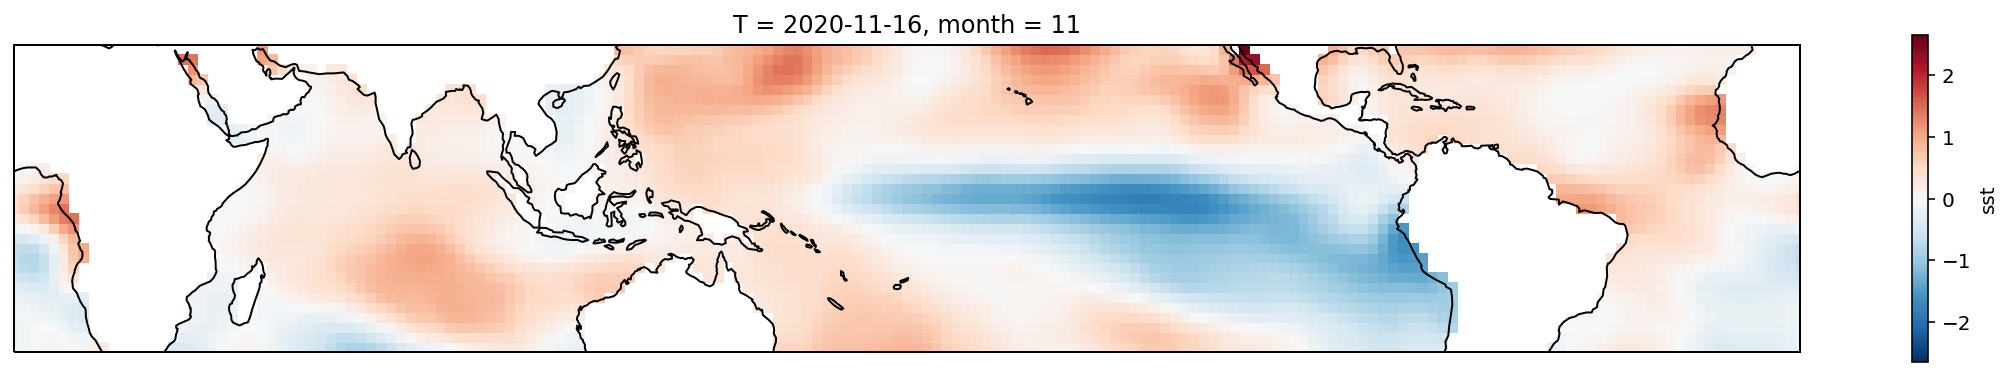

In [39]:
# Prettier plot
proj = ccrs.PlateCarree(central_longitude = 180)
fig, ax = plt.subplots(1, 1, subplot_kw = dict(projection = proj), figsize = (20,3))
ssta.isel(T = -1).plot(ax = ax, transform = ccrs.PlateCarree());
ax.coastlines();

## 3. Multi-dimensional data to 2D

### 3.1 Stack

"Stack any number of existing dimensions into a single new dimension."

http://xarray.pydata.org/en/stable/generated/xarray.DataArray.stack.html

In [40]:
ssta2Dv1 = ssta.stack(YX=('Y', 'X'))
ssta2Dv1

<xarray.DataArray 'sst' (T: 491, YX: 5580)>
array([[ 0.29153252,  0.20361137,  0.10206985, ...,         nan,
                nan,         nan],
       [ 0.36766243,  0.27153778,  0.15734482, ...,         nan,
                nan,         nan],
       [ 0.24359322,  0.25164413,  0.22725487, ...,         nan,
                nan,         nan],
       ...,
       [ 0.38923073,  0.33103752,  0.25232124, ...,         nan,
                nan,         nan],
       [ 0.14290619,  0.16953278,  0.19257736, ...,         nan,
                nan,         nan],
       [-0.12275696, -0.07427216, -0.0254097 , ...,         nan,
                nan,         nan]], dtype=float32)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-16T12:00:00 ... 2020-11-16
    month    (T) int64 1 2 3 4 5 6 7 8 9 10 11 12 ... 12 1 2 3 4 5 6 7 8 9 10 11
  * YX       (YX) MultiIndex
  - Y        (YX) float64 -30.0 -30.0 -30.0 -30.0 -30.0 ... 30.0 30.0 30.0 30.0
  - X        (YX) float64 0.0 2.0 4.0 6.0 8.0 ... 350.0 352.0 354.0 356.0 358.0

In [41]:
ssta2Dv1.shape

(491, 5580)

In [42]:
# Small example

arr = xr.DataArray(np.arange(6).reshape(2, 3), 
                   coords=[("x", ["x1", "x2"]), 
                           ("y", ['y1', 'y2', 'y3'])])
arr

<xarray.DataArray (x: 2, y: 3)>
array([[0, 1, 2],
       [3, 4, 5]])
Coordinates:
  * x        (x) <U2 'x1' 'x2'
  * y        (y) <U2 'y1' 'y2' 'y3'

In [43]:
# Row coordinate first?

arr1D = arr.stack(XY = ('x', 'y'))
arr1D

<xarray.DataArray (XY: 6)>
array([0, 1, 2, 3, 4, 5])
Coordinates:
  * XY       (XY) MultiIndex
  - x        (XY) object 'x1' 'x1' 'x1' 'x2' 'x2' 'x2'
  - y        (XY) object 'y1' 'y2' 'y3' 'y1' 'y2' 'y3'

In [25]:
arr1D.XY

<xarray.DataArray 'XY' (XY: 6)>
array([('x1', 'y1'), ('x1', 'y2'), ('x1', 'y3'), ('x2', 'y1'), ('x2', 'y2'),
       ('x2', 'y3')], dtype=object)
Coordinates:
  * XY       (XY) MultiIndex
  - x        (XY) object 'x1' 'x1' 'x1' 'x2' 'x2' 'x2'
  - y        (XY) object 'y1' 'y2' 'y3' 'y1' 'y2' 'y3'

### 3.2 Reshape

In [26]:
nt, ny, nx = ssta.shape
nt, ny, nx

(491, 31, 180)

In [27]:
ssta2Dv2 = ssta.values.reshape(nt,ny*nx)
ssta2Dv2.shape

(491, 5580)

In [28]:
# Same numbers? Why not?
np.max(np.abs(ssta2Dv1-ssta2Dv2)).values

array(0.)

In [29]:
ssta2D = ssta2Dv1

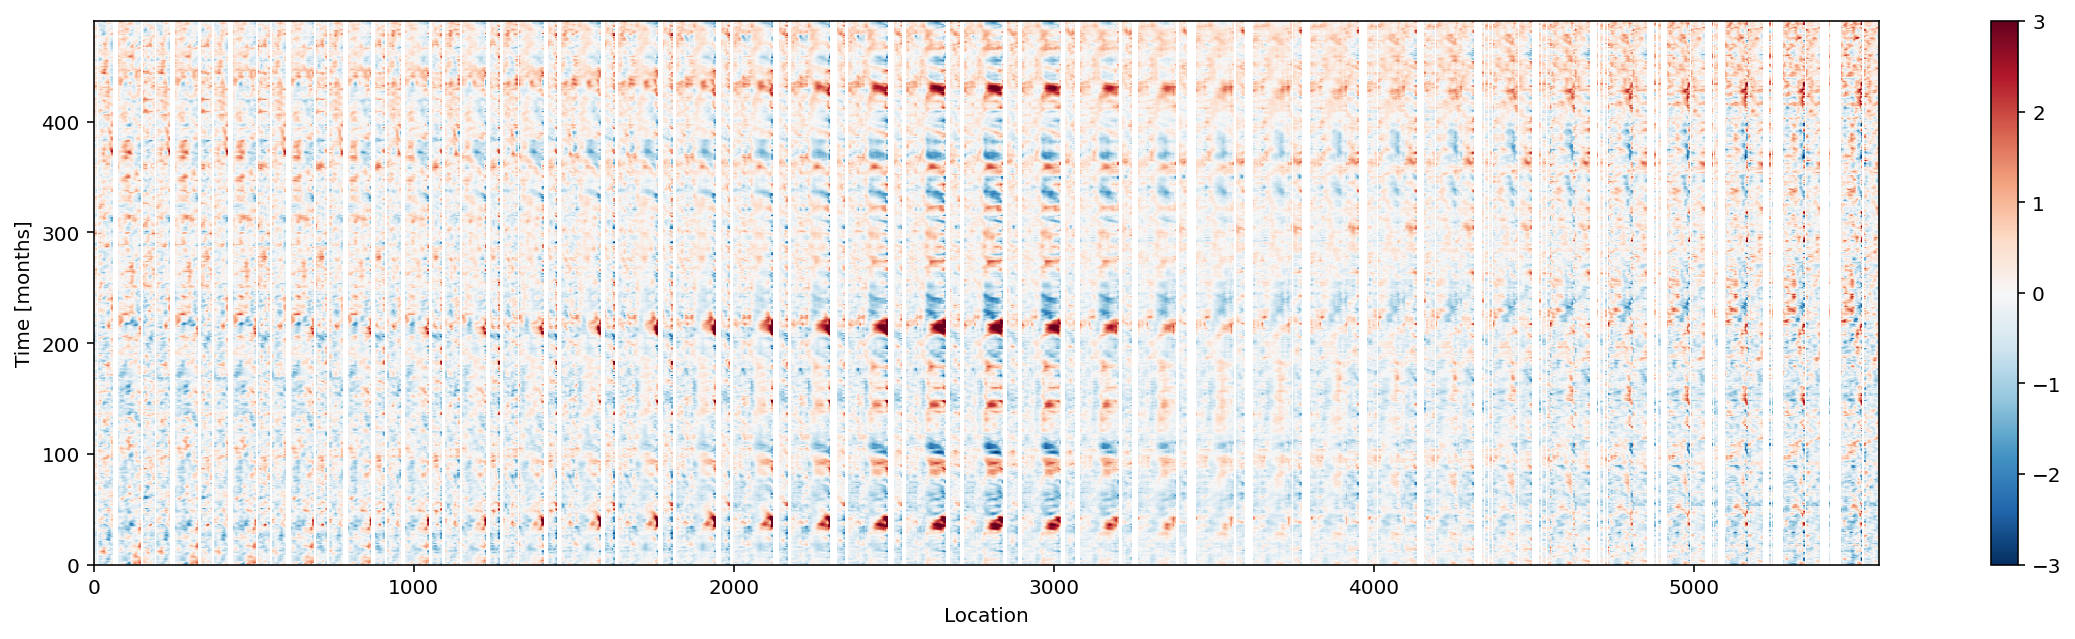

In [30]:
fig, ax = plt.subplots(figsize = (20, 5))
g = ax.pcolormesh(ssta2D, cmap='RdBu_r', vmin=-3, vmax=3);
ax.set_xlabel('Location')
ax.set_ylabel('Time [months]')
plt.colorbar(g);

### 3.3 Almost a matrix

In [31]:
#What are the white lines?
np.sum(~np.isnan(ssta2D.values))

2077421

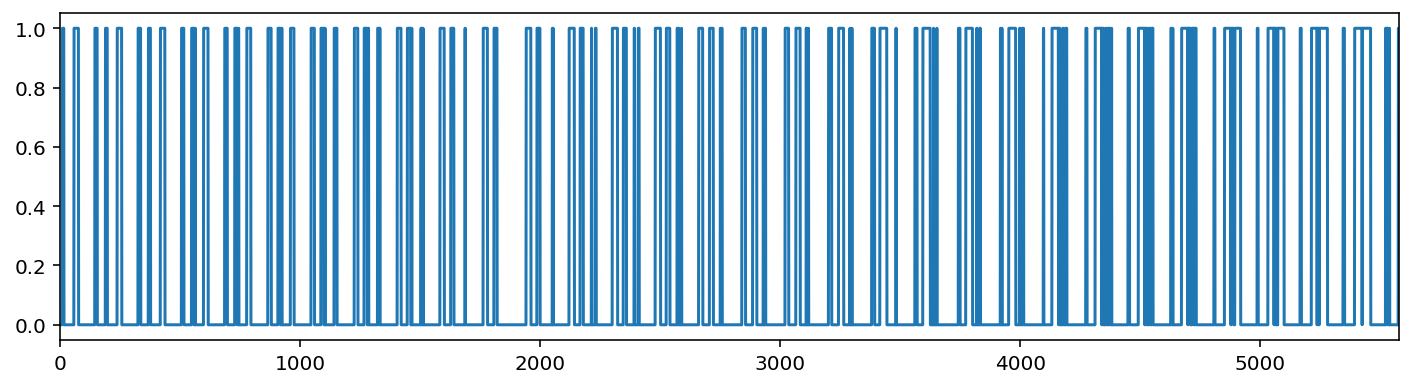

In [32]:
goodXY = ~np.isnan(ssta2D[0,:])
fig, ax = plt.subplots(figsize=(12,3))
plt.plot(~goodXY);
ax.set_xlim(0, ny*nx);

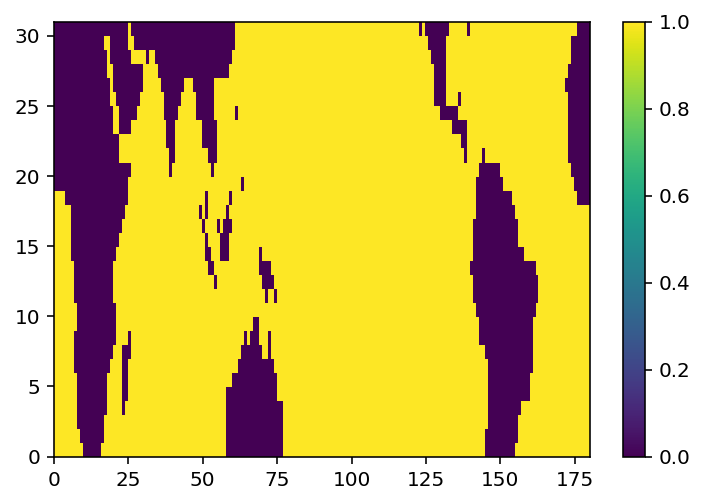

In [33]:
plt.pcolormesh(goodXY.values.reshape(ny, nx));
plt.colorbar();

The "good" values are a rank-1 matrix

$uv^T$ rank-1 matrix. 

columns of ones times the row of good values

In [34]:
# "Obvious" matrix multiplication may give an error if 1D array is not made into a column (2D)
goodXY_matrix = np.ones((nt, 1)) @ goodXY.values.reshape(1, ny * nx)
goodXY_matrix.shape, ssta2D.shape

((491, 5580), (491, 5580))

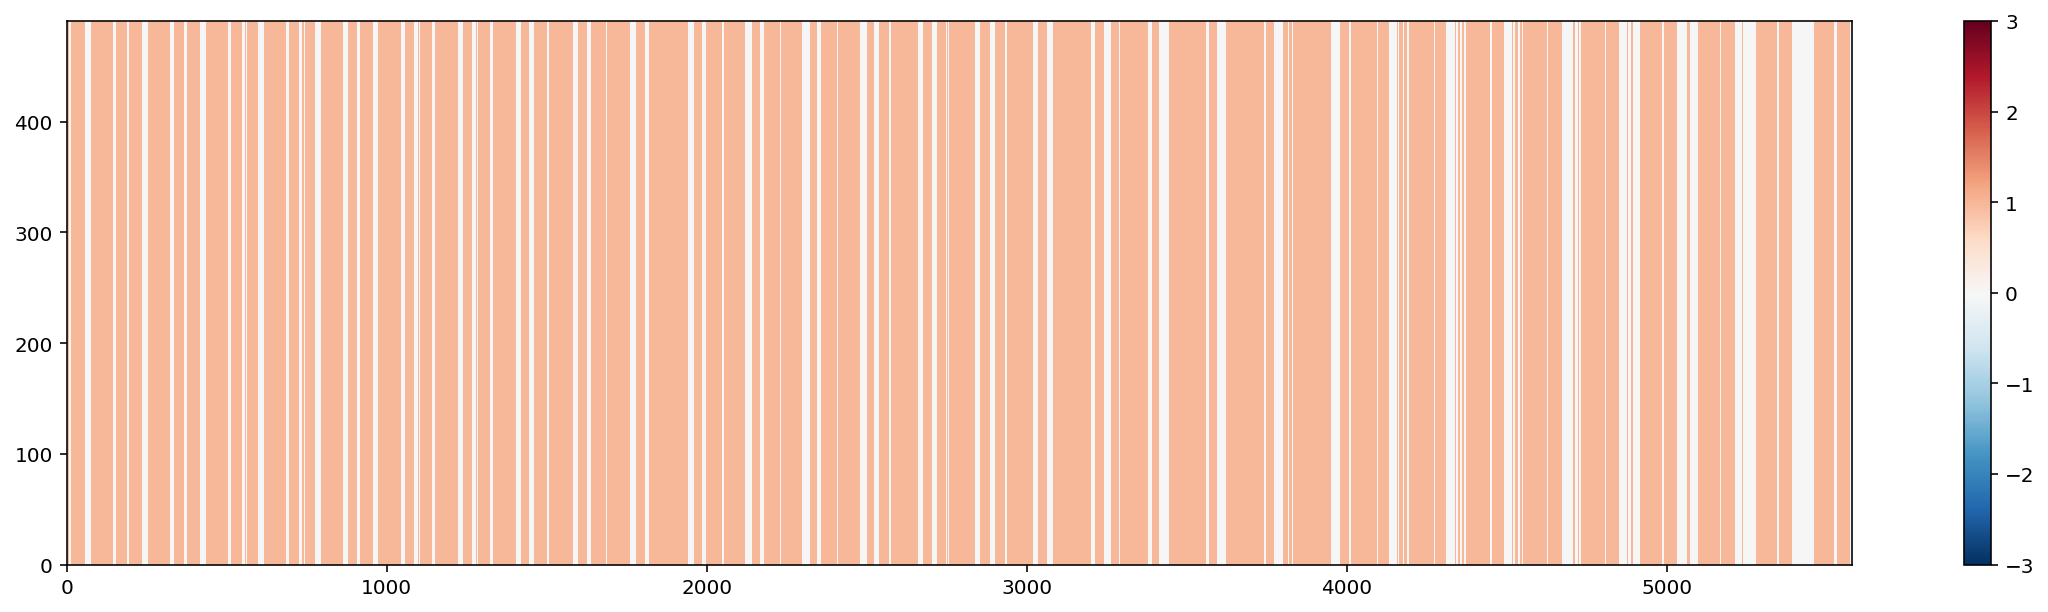

In [35]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.pcolormesh(goodXY_matrix, cmap='RdBu_r', vmin=-3, vmax=3);
plt.colorbar();

Create a matrix that only has the non-missing values. `.values` makes the xarray DataArray into a numpy array. 

In [36]:
dta = ssta2D.values[:,goodXY]
nt, nl = dta.shape

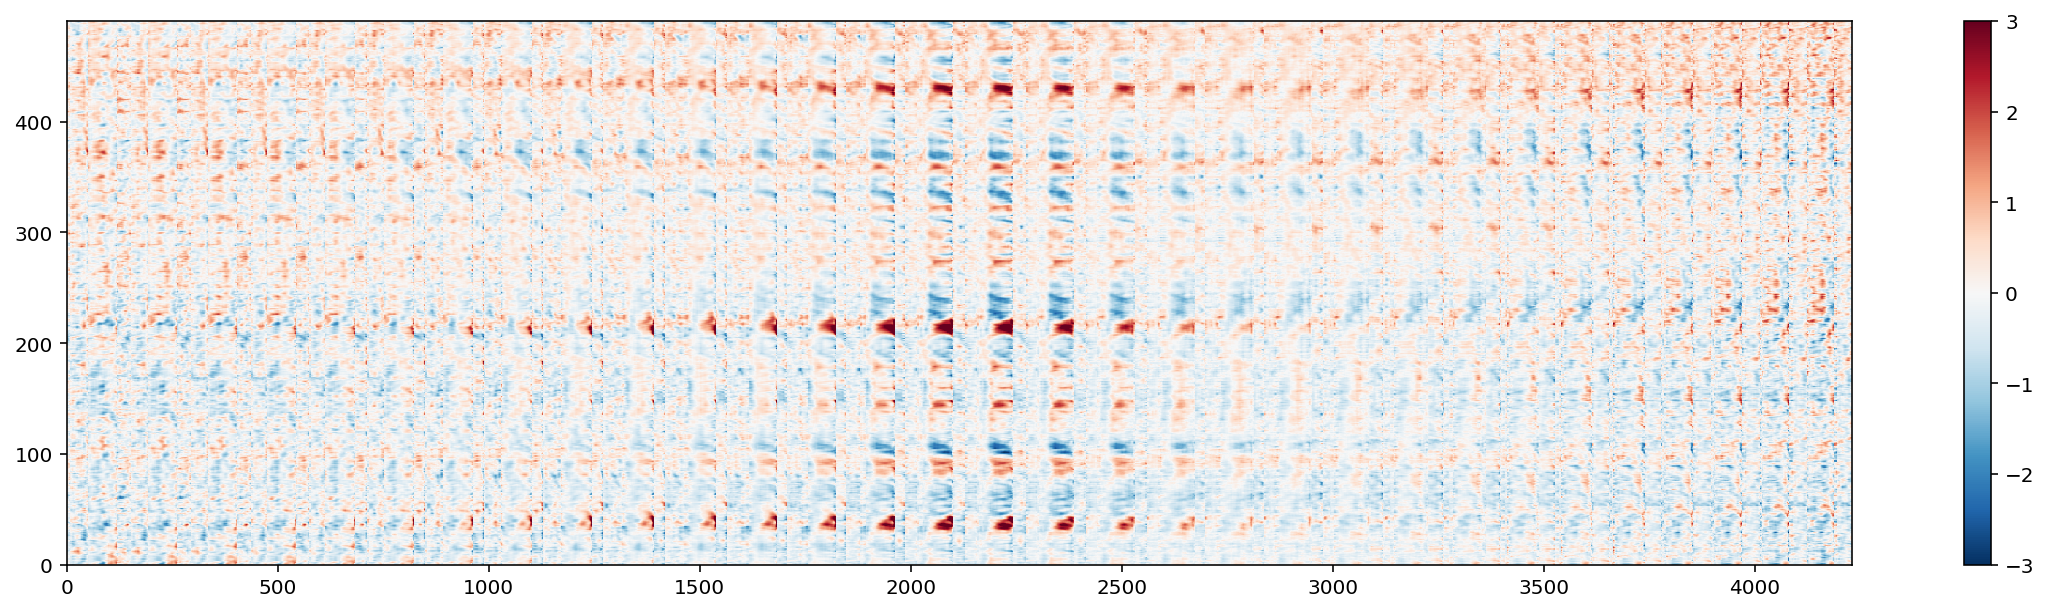

In [37]:
fig, ax = plt.subplots(figsize=(20, 5))
plt.pcolormesh(dta, cmap='RdBu_r', vmin=-3, vmax=3);
plt.colorbar();

In theory, one can have time vary along rows or columns. In practice, it is less confusing to choose a data model and stick with it. 

My mental image is that every column is a different time, which means that each row is *time series*, and we plot time series horizontally, like rows. Therefore, we take the transpose of `dta`.

### 3.4 A matrix

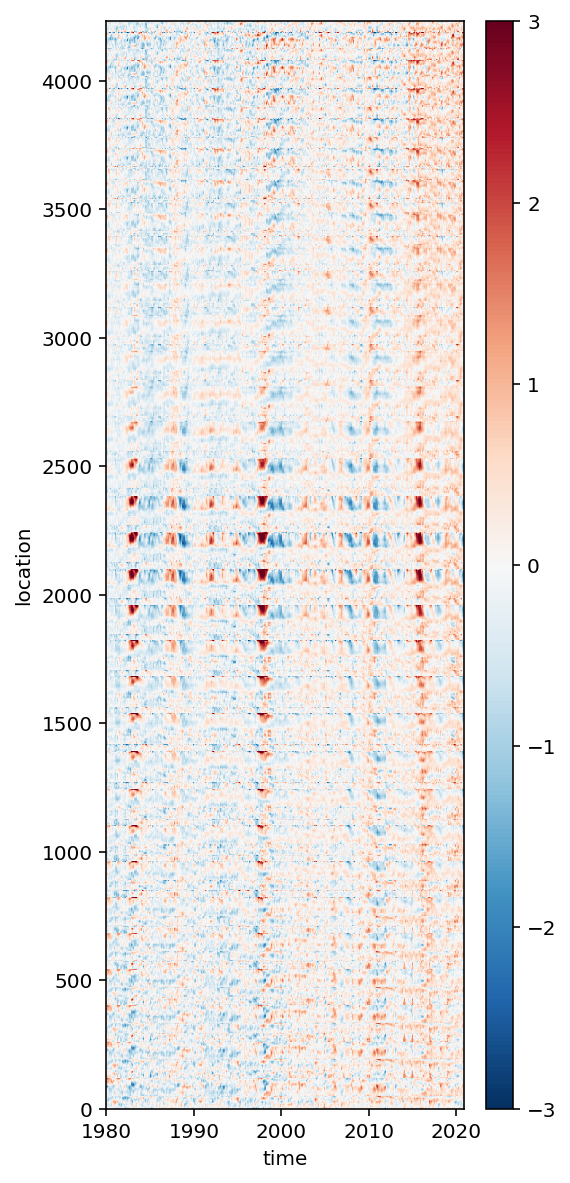

In [38]:
A = dta.T
time = np.arange(nt)/12 + 1980

fig, ax = plt.subplots(figsize=(4, 10))
g = ax.pcolormesh(time, np.arange(nl), A, cmap='RdBu_r', vmin=-3, vmax=3);
ax.set_xlabel('time')
ax.set_ylabel('location')
plt.colorbar(g, fraction = 0.15, aspect = 40);

In [ ]:
np.prod(A.shape)

How are we to "understand" the data? What the important features? And do we need all those numbers?

## 4. SVD/PCA

(More details in the week 11 notes on Courseworks)

The singular value decomposition in a nutshell. 

Suppose that we put our data into a $M \times N$ matrix $A$. $M$ is number of locations (rows), and $N$ is the number of time samples (columns). Then,

$$ A = U S V^T $$

where 
- $U$ is a $M \times M$ orthogonal matrix whose columns are called *left singular vectors*. The columns of $U$ are the spatial patterns. The columns of $U$ are eigenvectors of $AA^T = U S S^T U^T$.
- $V$ is an orthogonal matrix whose columns are called *right singular vectors*. The columns of $V$ are the time series. The columns of $V$ are eigenvectors of $A^TA = V S^T S V^T$.
- $S$ is a $M \times N$ matrix with $r$ positive elements $\sigma_1, \sigma_2, \dots, \sigma_r$ called *singular values* along its diagonal. The squares of the singular values are eigenvalues of $AA^T$ and $A^TA$. Singular values are ordered from largest to smallest, $$\sigma_1 \ge  \sigma_2 \ge \dots, \sigma_r > 0 $$

### 4.1 The economy SVD

$S$ is $M \times N$ and has $N -r$ columns and $M-r$ rows that are exactly zero.

$$S=
\begin{bmatrix}
\sigma_1 &  0 &  \dots & 0 & 0 & \cdots & 0 \\
0 & \sigma_2 &  \dots & 0 & 0& \cdots & 0 \\
0 & 0 &  \dots & \sigma_{r-1} & 0& \cdots & 0 \\
0 & 0 &  \dots & 0 & \sigma_r& \cdots & 0 \\
0 & 0 &  \dots & 0 & 0& \cdots & 0 \\
\vdots & \vdots &  \dots &  \vdots& \vdots & \cdots & \vdots \\
0 & 0 &  \dots & 0 & 0 & \cdots & 0 \\
\end{bmatrix}
$$

This means that we can replace $U$, $V$, and $S$ by $U_r$, $V_r$, and $S_r$, respectiveley,  which contain their first $r$ columns.

$$U_r =
\begin{bmatrix}
u_1 & u_2 & \dots & u_r\\
\end{bmatrix}
$$

$$V_r =
\begin{bmatrix}
v_1&  v_2 & \dots & v_r\\
\end{bmatrix}
$$

$$S_r =
\begin{bmatrix}
\sigma_1 &  0 &  \dots & 0 & 0\\
0 & \sigma_2 &  \dots & 0 & 0\\
0 & 0 &  \dots & \sigma_{r-1} & 0\\
0 & 0 &  \dots & 0 & \sigma_r\\
\end{bmatrix}
$$

Note that $U_r$ and $V_r$ are not square, but $U_r^T U_r = I$ and $V_r^T V_r = I$ because their columns are orthonormal.

Now, without approximation
$$ A = U_r S_r V_r^T = \sum_{i=1}^r \sigma_i u_i v_i^T$$

Every matrix is the sum of rank-1 matrices, which are easy to understand. 

(Note that the columns of $U_r$ and $V_r$ are orthonormal bases for the column and row spaces of $A$, respectively.

### 4.2 The Eckart–Young–Mirsky theorem 

The *best* rank-$k$ approximation of $A$ is

$$A_k = \sum_{i=1}^k \sigma_i u_i v_i^T$$

Best is in the sense of making the error $\| A - A_k\|^2$ of the approximation small, and where the matrix norm $ \| \cdot\|$ is  the spectral norm $\| \cdot \|_2$ defined by

$$\|A\|_2^2 = \sigma_1^2 \,,$$ 

or the Frobenius norm $\| \cdot \|_F$ defined by

$$\|A\|_F^2 = \sum_{i=1}^r \sigma_i^2 $$ 

#### 4.2.1 The Frobenius norm

Note that 

$$\|A\|_F^2 = \text{trace} (A^T A) $$

(Why? What is are two useful definitions of the trace of a square matrix?)

$$\|A\|_F^2 = \sum_{i=1}^N (A^T A)_{ii} $$

(What are the diagonal elements of $A^T A$?)

$$\|A\|_F^2 = \sum_{i=1}^N \sum_{j=1}^M A_{ij}^2 $$

The squared Frobenius norm of a matrix is the sum of the squares of its elements, which is like the square lenght of a vector.

When the data (elements of $A$) are anomalies, then $\|A\|_F^2$ is proportional to the total variance (variance summed over spatial locations), and the SVD is the multivariate statistical method called Principle Component Analysis (PCA).

https://en.wikipedia.org/wiki/Principal_component_analysis

In [70]:
# SVD
from scipy import linalg
U, S, Vt = linalg.svd(A, full_matrices=False)
V = Vt.T

# save for later
S1 = S

In [71]:
# Some checks
# economy
print(U.shape)
print(V.shape)
print(S.shape)

(4231, 491)
(491, 491)
(491,)


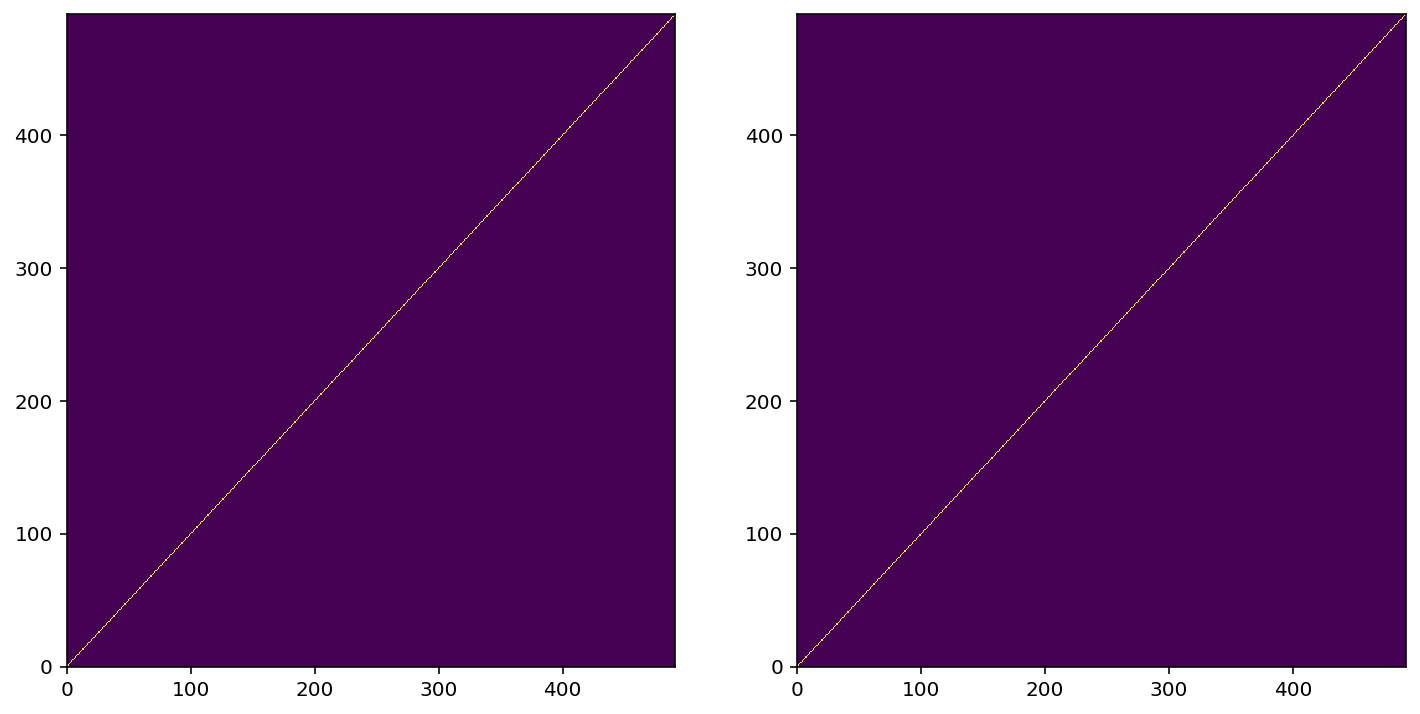

In [72]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

ax = axs[0]
ax.pcolormesh(U.T @ U)

ax = axs[1]
ax.pcolormesh(V.T @ V);

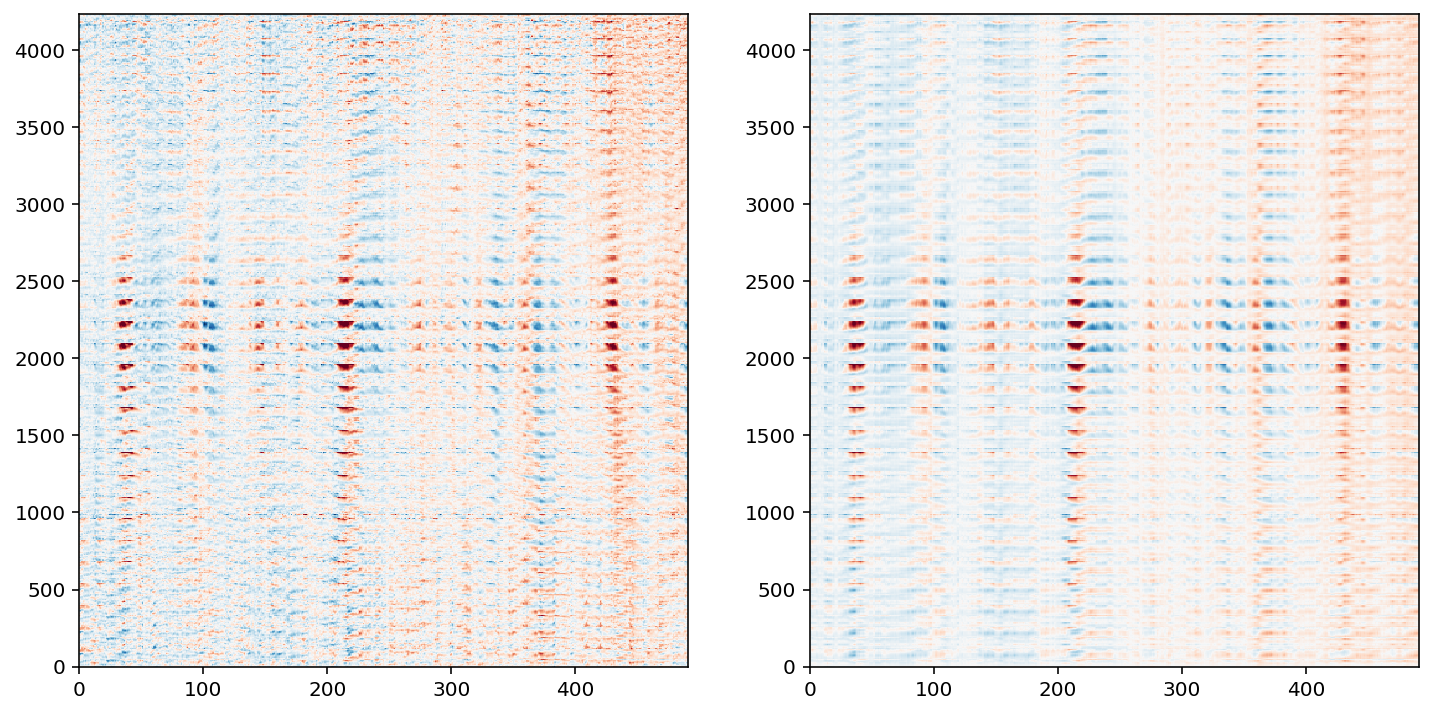

In [56]:
fig, axs = plt.subplots(1, 2, figsize = (12, 6))

# A = USV^T
Asvd = U @ np.diag(S) @ V.T
ax = axs[0]
ax.pcolormesh(Asvd, cmap='RdBu_r', vmin=-3, vmax=3)

# A = USV^T rank-k approximation
k = 5
A_approx = U[:, :k] @ np.diag(S[:k]) @ V[:,:k].T
ax = axs[1]
ax.pcolormesh(A_approx, cmap='RdBu_r', vmin=-3, vmax=3);


In [75]:
ssta2D_approx = ssta2D.copy()
ssta2D_approx.values[:,goodXY] = A_approx.T
ssta_approx = ssta2D_approx.unstack('YX')

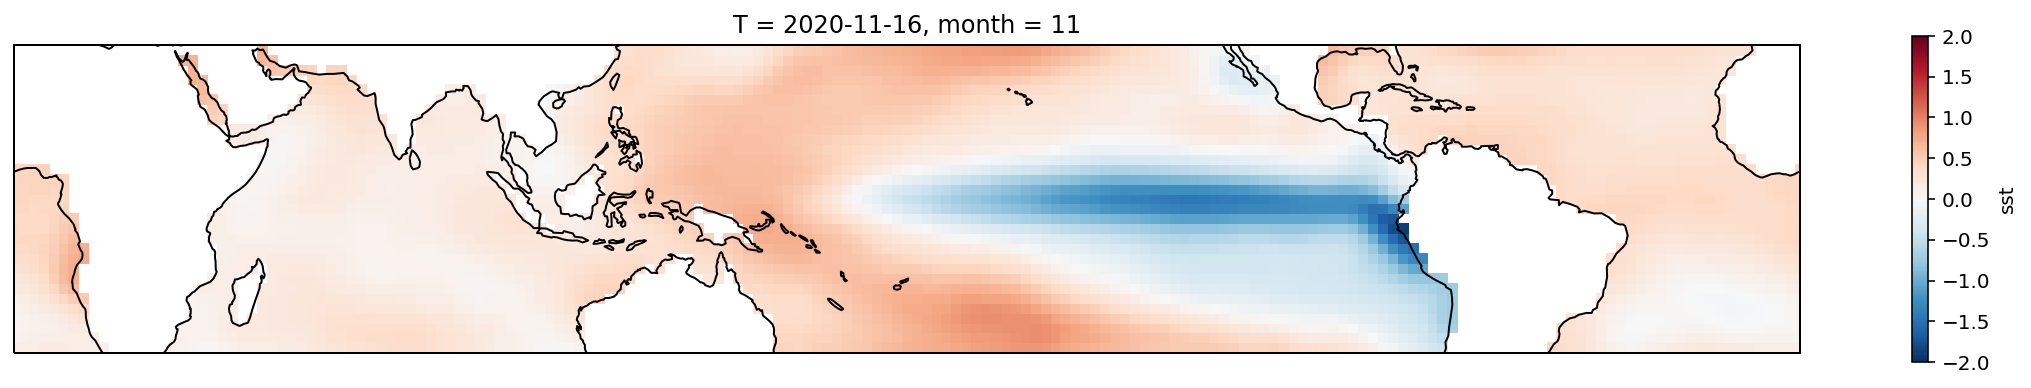

In [76]:
# plot the approximation
proj = ccrs.PlateCarree(central_longitude = 180)
fig, ax = plt.subplots(1, 1, subplot_kw = dict(projection = proj), figsize = (20,3))
ssta_approx.isel(T = -1).plot(ax = ax, vmin = -2, transform = ccrs.PlateCarree());
ax.coastlines();

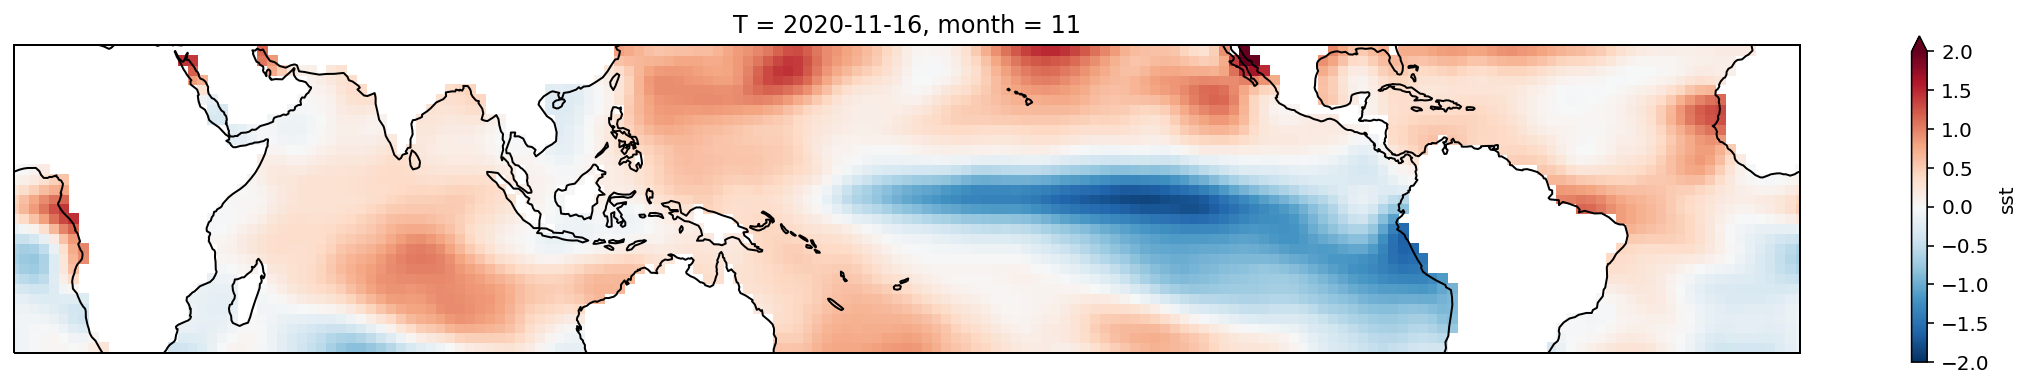

In [77]:
# plot the original
proj = ccrs.PlateCarree(central_longitude = 180)
fig, ax = plt.subplots(1, 1, subplot_kw = dict(projection = proj), figsize = (20,3))
ssta.isel(T = -1).plot(ax = ax, vmin = -2, transform = ccrs.PlateCarree());
ax.coastlines();

### 4.3 How good is the low-rank approximation?

The low-rank approximation:
$$ A_k = \sum_{i=1}^k \sigma_i u_i v_i^T \,.$$

No approximation:
$$ A = \sum_{i=1}^r \sigma_i u_i v_i^T \,.$$

The error of the approximation?
$$ A - A_k =  \sum_{i= k+1}^r \sigma_i u_i v_i^T$$

How big is the error (with units)?

$$ \| A - A_k \|^2_2 = \sigma_{k+1}^2 $$

$$ \| A - A_k \|^2_F = \sum_{i= k+1}^r \sigma_i ^2 $$

How big is the error (without units)?

Fraction of unexplained (by the PCA approximation) variance
$$ \frac{\| A - A_k \|^2_F}{\|A\|_F^2}$$

Fraction of explained (by the PCA approximation) variance
$$ 1 - \frac{\| A - A_k \|^2_F}{\|A\|_F^2} = 1 - \frac{\sum_{i= k+1}^r \sigma_i ^2}{\sum_{i=1}^r \sigma_i ^2} = \frac{\sum_{i= 1}^k \sigma_i ^2}{\sum_{i=1}^r \sigma_i ^2}$$



Ratios of sums of squares = fraction of variance

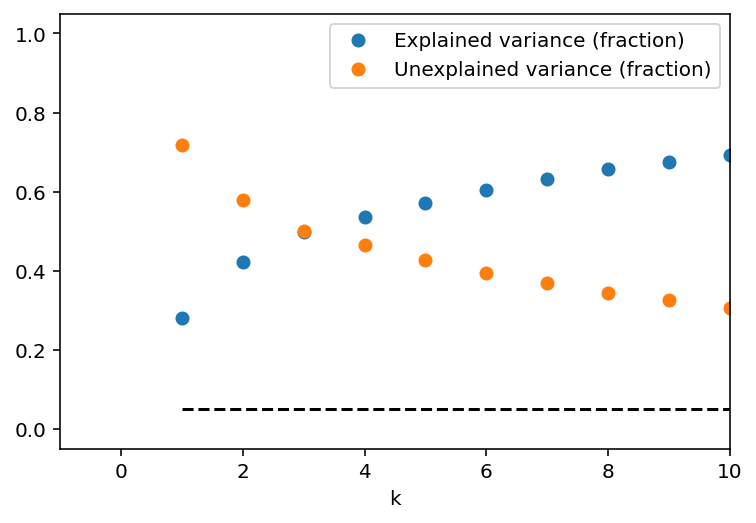

In [84]:
N = nt
Ns = np.arange(1, N + 1)
#plt.plot(Ns, S**2/np.sum(S**2), label ='?');
plt.plot(Ns, np.cumsum(S**2)/np.sum(S**2), 'o',  label = 'Explained variance (fraction)')
plt.plot(Ns, 1. - np.cumsum(S**2)/np.sum(S**2), 'o', label = 'Unexplained variance (fraction)')
plt.xlabel('k')
plt.plot(Ns, np.ones_like(Ns) * 0.05, 'k--')
plt.legend();
plt.xlim(-1, 10);

### 4.4 Plotting

How to plot the terms (rank-1 matrices) in the sum? Three plots?

$$\sigma_i\,, u_i\,, v_i^T$$

Two?
$$(\sigma_i u_i)\,, v_i^T$$

Or two?
$$ u_i\,, (\sigma_i v_i^T)$$
Or what?

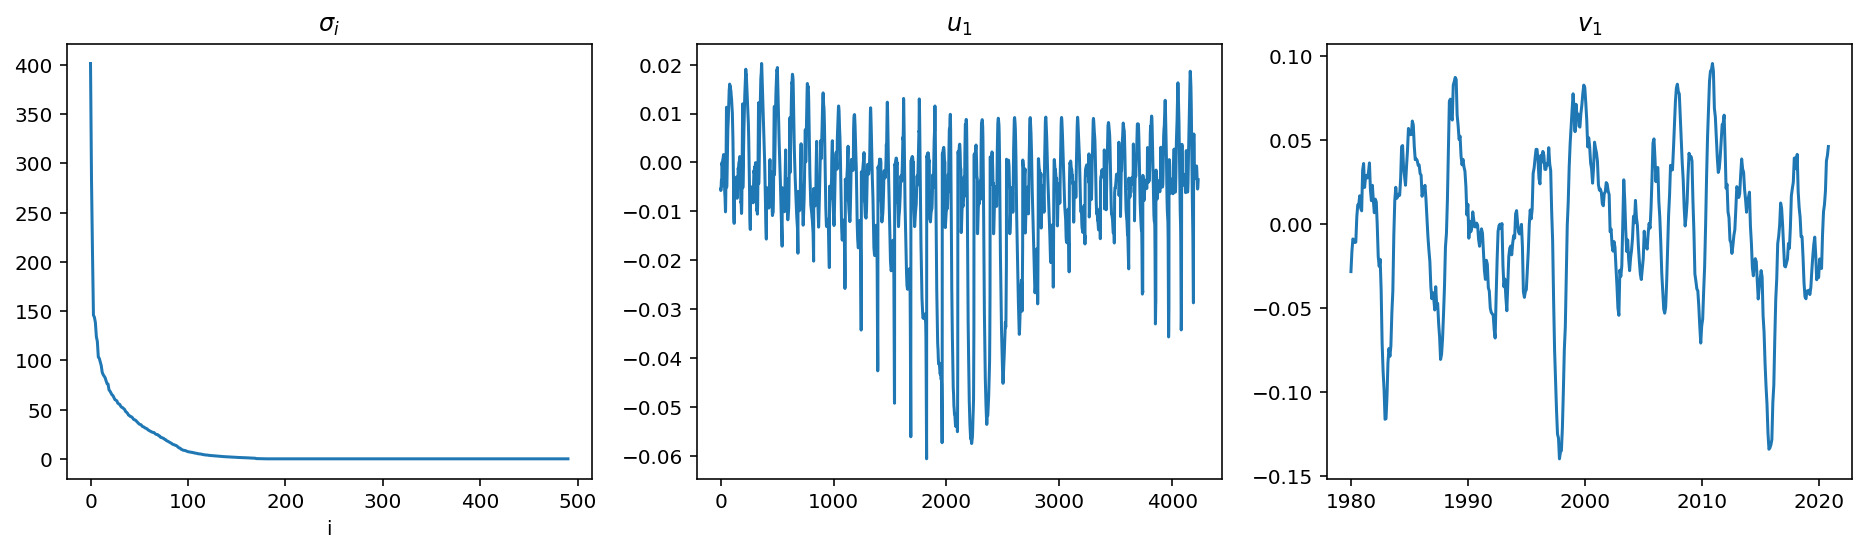

In [86]:
fig, axs = plt.subplots(1, 3, figsize=(16, 4))

ax = axs[0]
ax.plot(S)
ax.set_title(r'$\sigma_i$')
ax.set_xlabel('i')

ax = axs[1]
ax.plot(U[:,0]);
ax.set_title('$u_1$')


ax = axs[2]
ax.plot(time, V[:,0]);
ax.set_title('$v_1$');

What is the reason for the amplitude of the plots?

$v_i$ is a time series. It is handy to normalize it to have unit variance and call it a *principle component*

$$ \text{PC}_i = \sqrt{N - 1} v_i $$
Why does this work?

Then what we take out of $v_i$ we put into the *empirical orthognal function* along with the singular value
$$ \text{EOF}_i = \sigma_i \frac{1}{\sqrt{N - 1}} u_i$$

Then 
$$\text{data} = A = \sum_{i=1}^r (-1)\text{EOF}_i (-1)\text{PC}_i $$

### 4.5 Properties of PCs and EOFs
1. PCs are uncorrelated. Why?
- Because $v_i$'s are orthogonal
2. EOFs are ...
- orthogonal
3. The regression of a PC with the data is ...the EOF,  therefore EOFs are regression patterns
- $U S V^T v_1$

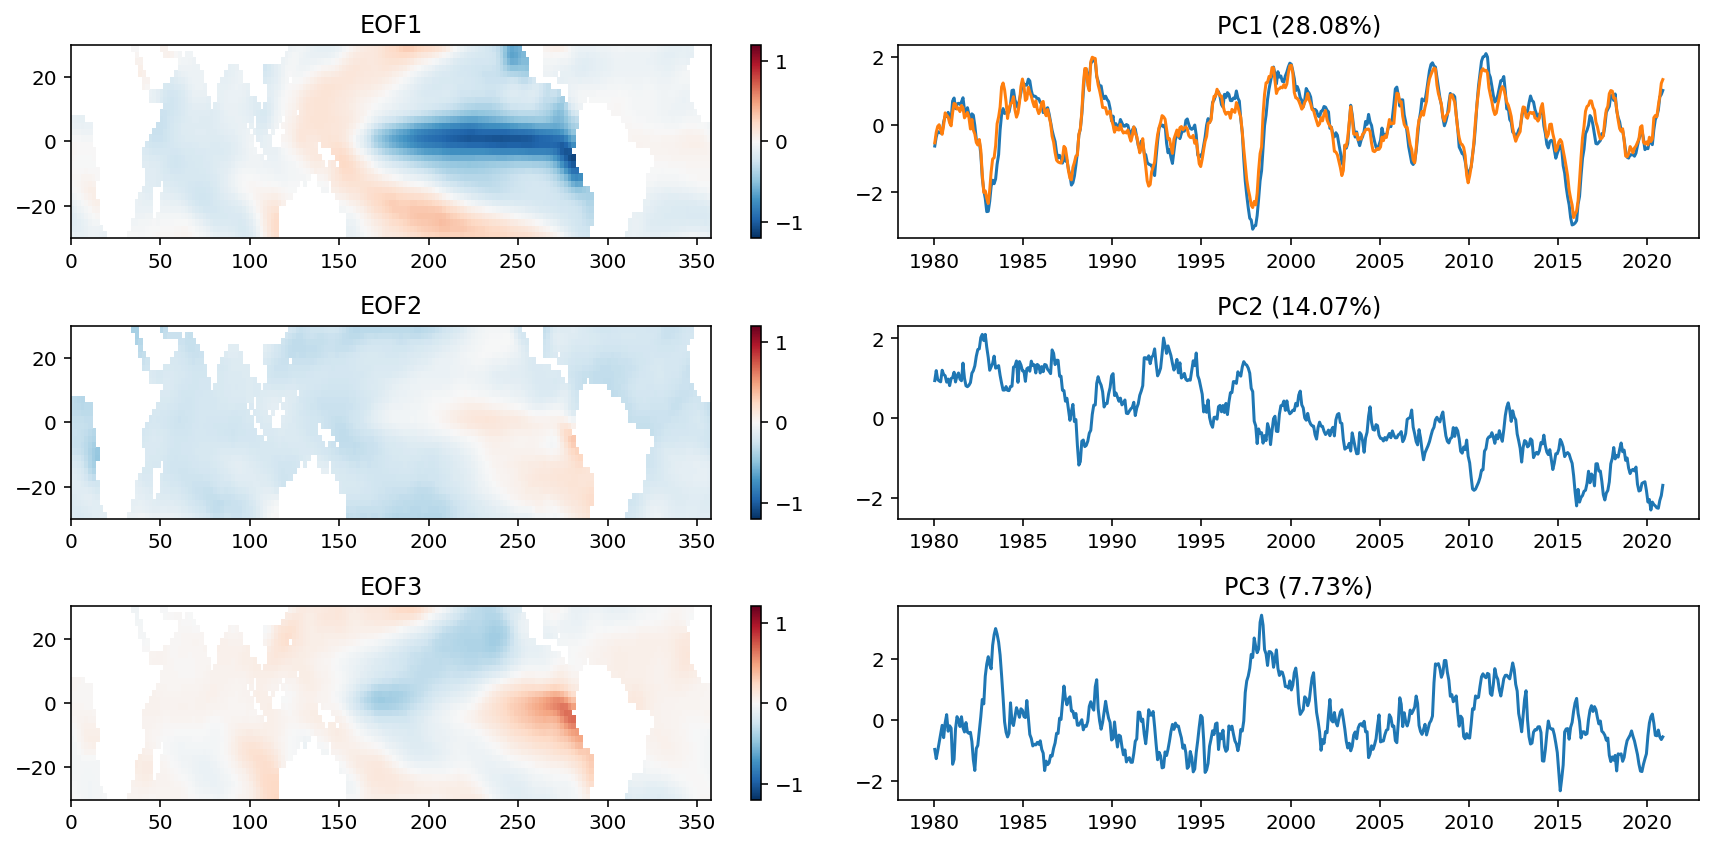

In [88]:
# k = number of EOFs to look at
k = 3

# EOFs are for plotting and have the dimensions original maps (with missing values)
EOFs = np.zeros((ny * nx, k)) + np.nan
EOFs[goodXY,:] = U[:, 0:k] / np.sqrt(nt-1) @ np.diag(S[0:k])
EOFs = EOFs.reshape([ny, nx, k])

PCs = np.zeros((nt, k)) + np.nan
PCs[:,:] = V[:, 0:k] * np.sqrt(nt - 1)

VarExp = S**2/np.sum(S**2)

fig, axes = plt.subplots(k, 2, figsize=(12, 2*k))
for ii in range(0,k):
    g = axes[ii,0].pcolormesh(X,Y,EOFs[:,:,ii],cmap='RdBu_r',vmin=-1.2,vmax=1.2)
    plt.colorbar(g,ax=axes[ii,0])
    axes[ii,1].plot(T,PCs[:,ii])
    axes[ii,1].set_title('PC{} ({:2.2f}%)'.format(ii+1,100*VarExp[ii]))
    axes[ii,0].set_title('EOF{}'.format(ii+1))
plt.tight_layout()
fig.set_facecolor("white")

axes[0, 1].plot(T, -n34a);

### 4.6 Area weighting

Not are grids are equal, especially one near the poles.

Sensible to consider area-weighted variance (or squared error) as the measure 

$$\|A\|_W^2 = \sum_{j=1}^N \sum_{i=1}^M A_{ij}^2 w_{i} $$

where $w_{i}$ is the propotional to the area of location $i$. The area of location $i$ is propotional to ...
$\cos \text{lat}$?

$$\|A\|_W^2 = \| W^{1/2} A \|_F^2 = \text{trace} (A^T W A) = \| \tilde{A} \|_F^2  $$

where $W$ is the diagonal matrix whose $i$-th component is $w_i$ and $\tilde{A} = W^{1/2} A$. 

In [89]:
ssta_area_weighted = ssta*np.sqrt(np.cos(ssta.Y/180*np.pi))

ssta2D = ssta_area_weighted.stack(YX=('Y', 'X'))
dta = ssta2D.values[:,goodXY]
A = dta.T

from scipy import linalg
U, S, Vt = linalg.svd(A, full_matrices=False)
V = Vt.T

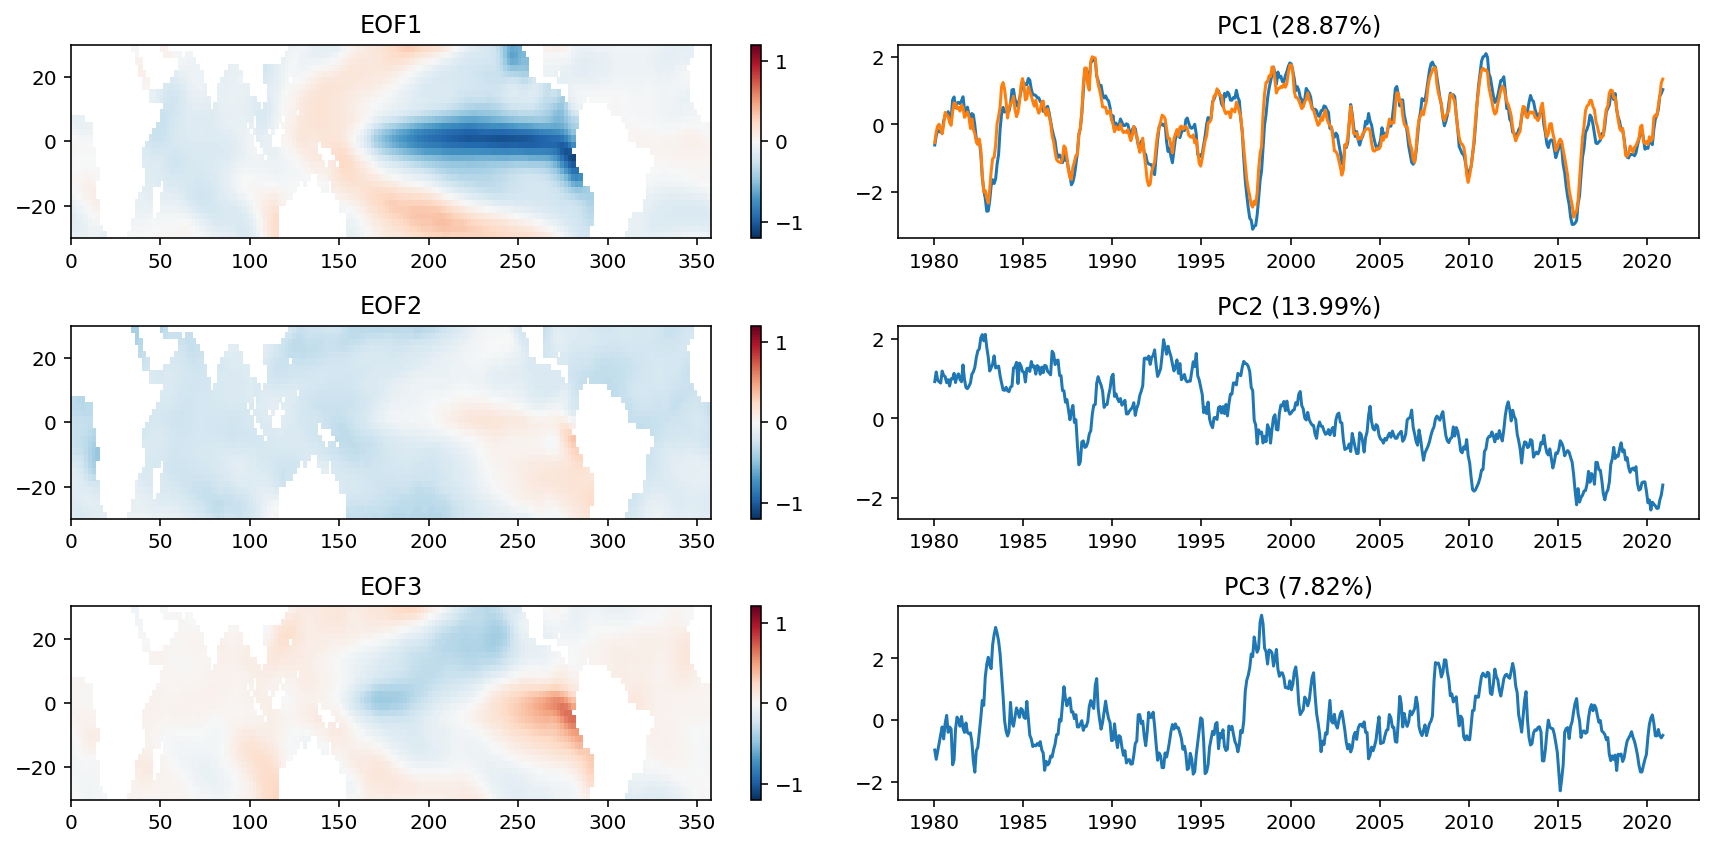

In [92]:
# k = number of EOFs to look at
k = 3

# EOFs are for plotting and have the dimensions original maps (with missing values)
EOFs = np.zeros((ny*nx, k)) + np.nan
EOFs[goodXY,:] = U[:, 0:k]/np.sqrt(nt-1) @ np.diag(S[:k])
EOFs = EOFs.reshape([ny, nx, k])
# broadcasting hack
w = np.sqrt(np.cos(ssta.Y/180*np.pi)).values
EOFs = EOFs/w[:, np.newaxis, np.newaxis]

PCs = np.zeros((nt, k)) + np.nan
PCs[:,:] = V[:, 0:k]*np.sqrt(nt-1)

VarExp = S**2/np.sum(S**2)

fig, axes = plt.subplots(k, 2, figsize=(12, 2*k))
for ii in range(0, k):
    g = axes[ii,0].pcolormesh(X,Y,EOFs[:,:,ii],cmap='RdBu_r',vmin=-1.2,vmax=1.2)
    plt.colorbar(g,ax=axes[ii,0])
    axes[ii,1].plot(T,PCs[:,ii])
    axes[ii,1].set_title('PC{} ({:2.2f}%)'.format(ii+1,100*VarExp[ii]))
    axes[ii,0].set_title('EOF{}'.format(ii+1))
plt.tight_layout()
fig.set_facecolor("white")

axes[0, 1].plot(T, -n34a);

### 4.7 Detrend the data

Trends explain a lot variablility because of the deviation from the mean, but may not be the variability that we are looking for. We can model a trends as ... a trend.

In [93]:
from scipy import signal

ssta_area_weighted = ssta*np.sqrt(np.cos(ssta.Y/180*np.pi))
ssta2D = ssta_area_weighted.stack(YX=('Y', 'X'))
dta = ssta2D.values[:,goodXY]
dta_detrend = signal.detrend(dta,axis=1)

A = dta_detrend.T

from scipy import linalg
U, S, Vt = linalg.svd(A, full_matrices=False)
V = Vt.T

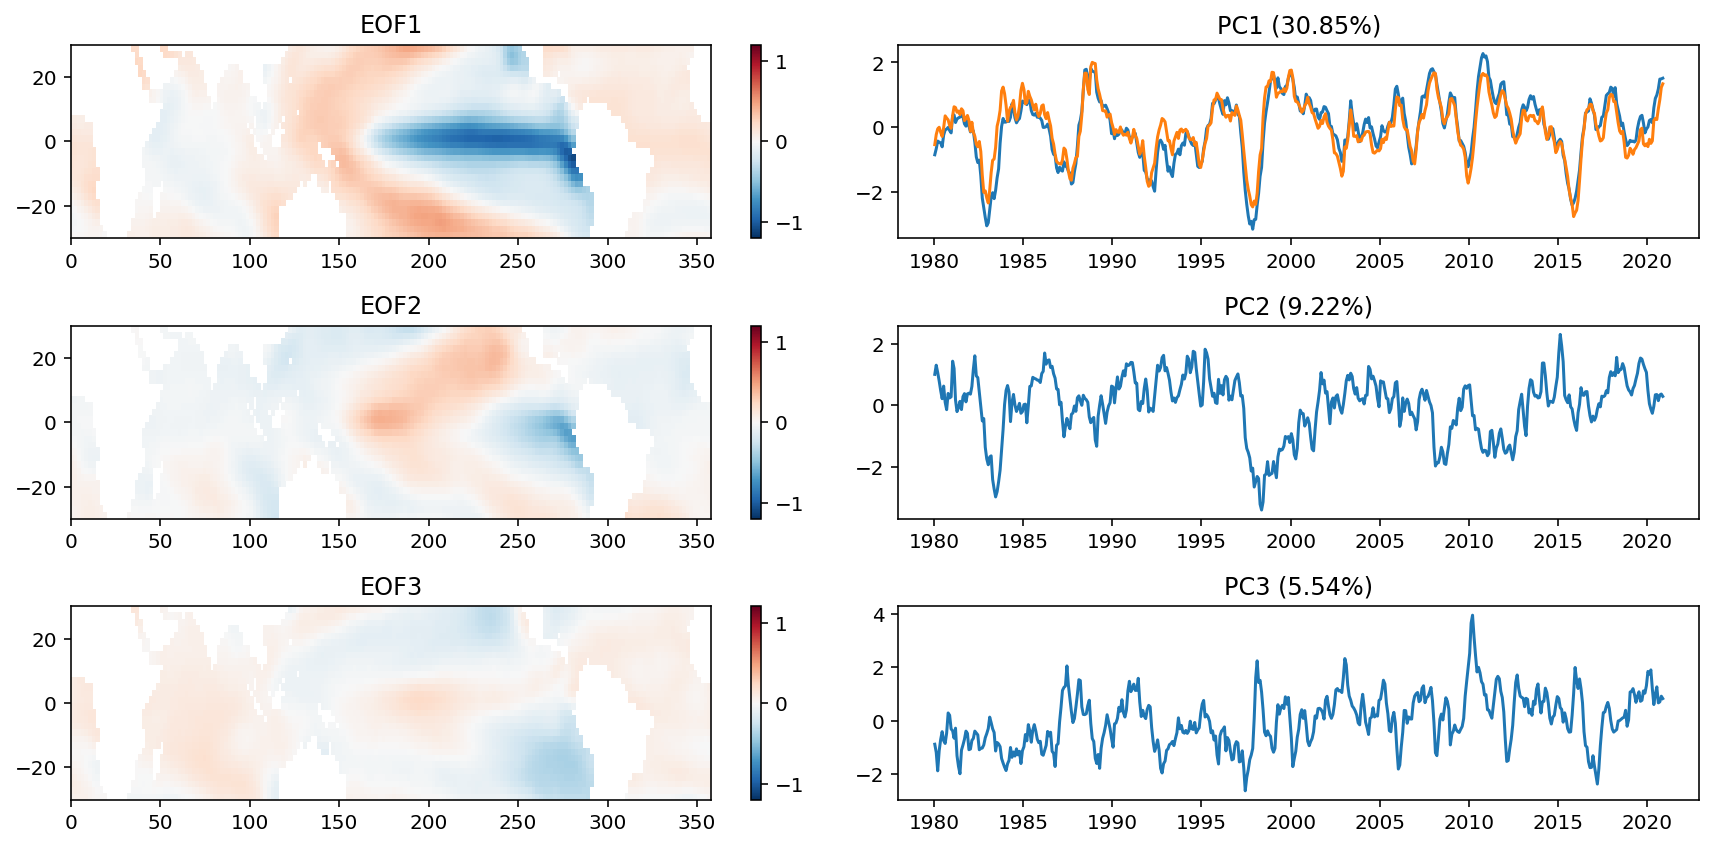

In [96]:
# k = number of EOFs to look at
k = 3

# EOFs are for plotting and have the dimensions original maps (with missing values)
EOFs = np.zeros((ny*nx, k)) + np.nan
EOFs[goodXY,:] = U[:, 0:k]/np.sqrt(nt-1) @ np.diag(S[:k])
EOFs = EOFs.reshape([ny, nx, k])
# broadcasting hack
w = np.sqrt(np.cos(ssta.Y/180*np.pi)).values
EOFs = EOFs/w[:, np.newaxis, np.newaxis]

PCs = np.zeros((nt, k)) + np.nan
PCs[:,:] = V[:, 0:k]*np.sqrt(nt-1)

VarExp = S**2/np.sum(S**2)

fig, axes = plt.subplots(k, 2, figsize=(12, 2*k))
for ii in range(0, k):
    g = axes[ii,0].pcolormesh(X,Y,EOFs[:,:,ii],cmap='RdBu_r',vmin=-1.2,vmax=1.2)
    plt.colorbar(g,ax=axes[ii,0])
    axes[ii,1].plot(T,PCs[:,ii])
    axes[ii,1].set_title('PC{} ({:2.2f}%)'.format(ii+1,100*VarExp[ii]))
    axes[ii,0].set_title('EOF{}'.format(ii+1))
plt.tight_layout()
fig.set_facecolor("white")

axes[0, 1].plot(T, -n34a);

## 5.ENSO flavors?

How one ENSO event differs from another

In [98]:
EP_CP = np.full((nt, 2), np.nan)
EP_CP[:, 0] = - (PCs[:,0] + PCs[:,1]) / np.sqrt(2.)
EP_CP[:, 1] = - (PCs[:,0] - PCs[:,1]) / np.sqrt(2.)

p = A @ EP_CP / nt

P = np.zeros((ny*nx, 2)) + np.nan
P[goodXY, :] = p
P = P.reshape(ny, nx, 2)

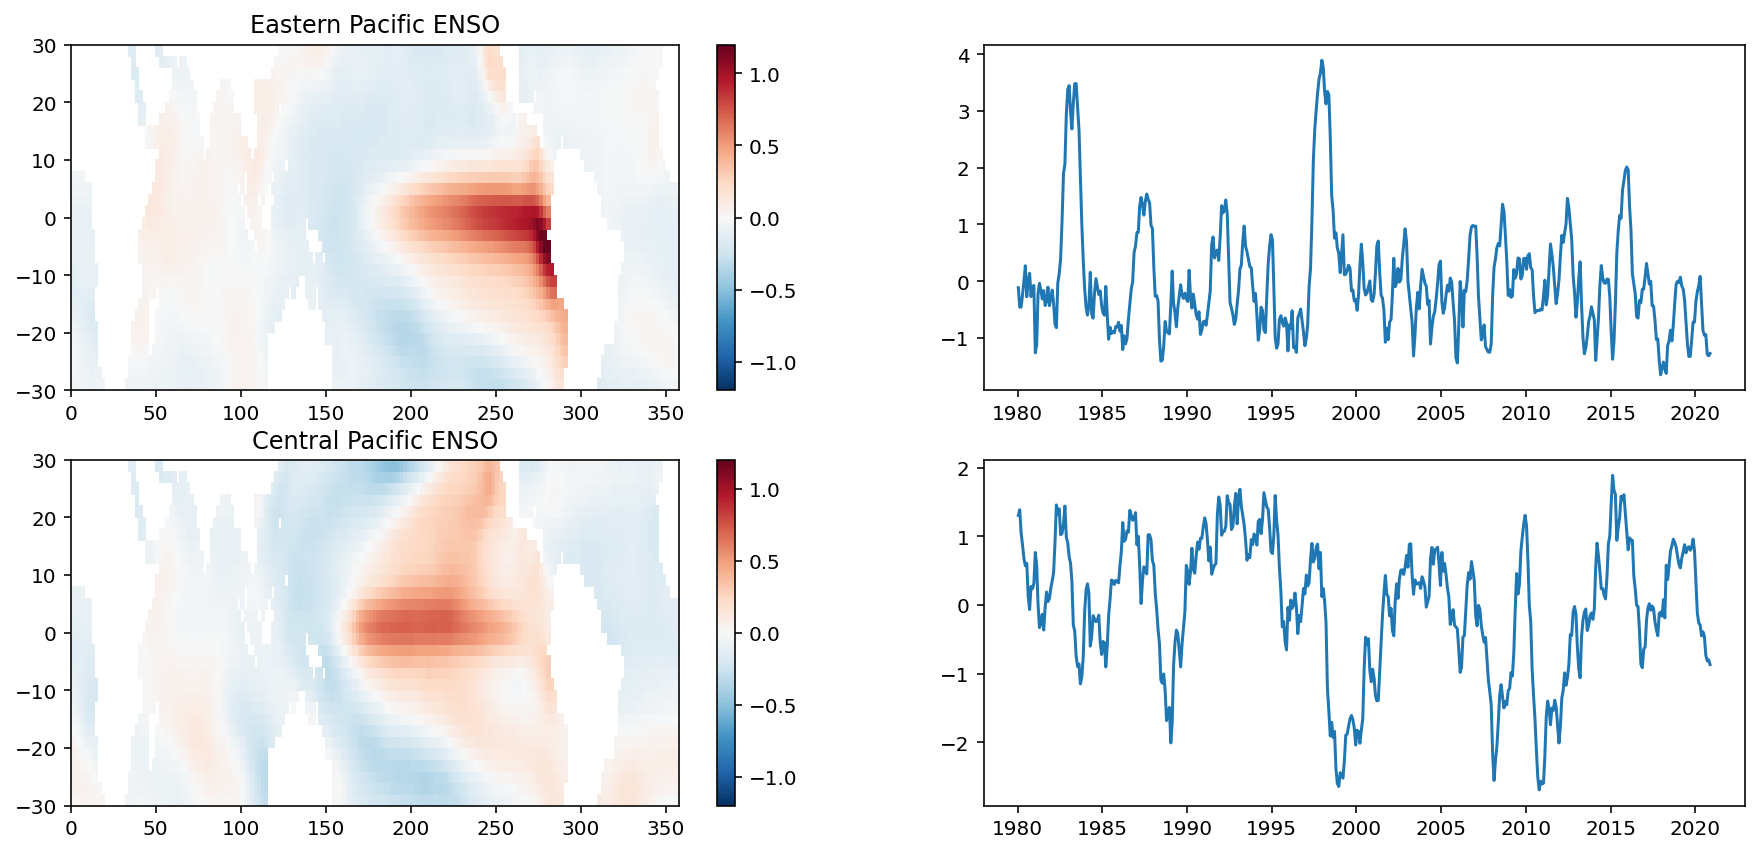

In [99]:
fig, axs = plt.subplots(2, 2, figsize = (15, 7))

for ii in range(0, 2):
    ax = axs[ii, 0]
    g = ax.pcolormesh(X, Y, P[:, :, ii], cmap='RdBu_r', vmin = -1.2, vmax = 1.2)
    plt.colorbar(g, ax=ax)
    ax = axs[ii, 1]
    ax.plot(T, EP_CP[:, ii])

axs[0, 0].set_title('Eastern Pacific ENSO');
axs[1, 0].set_title('Central Pacific ENSO');